In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

100%|██████████| 236M/236M [00:02<00:00, 97.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [ ]:
DATASET                 = "/root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1"
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
#PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)
PROGRESSIVE_EPOCHS = [5] * len(BATCH_SIZES)  # Set 5 epochs for testing


In [ ]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [ ]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset

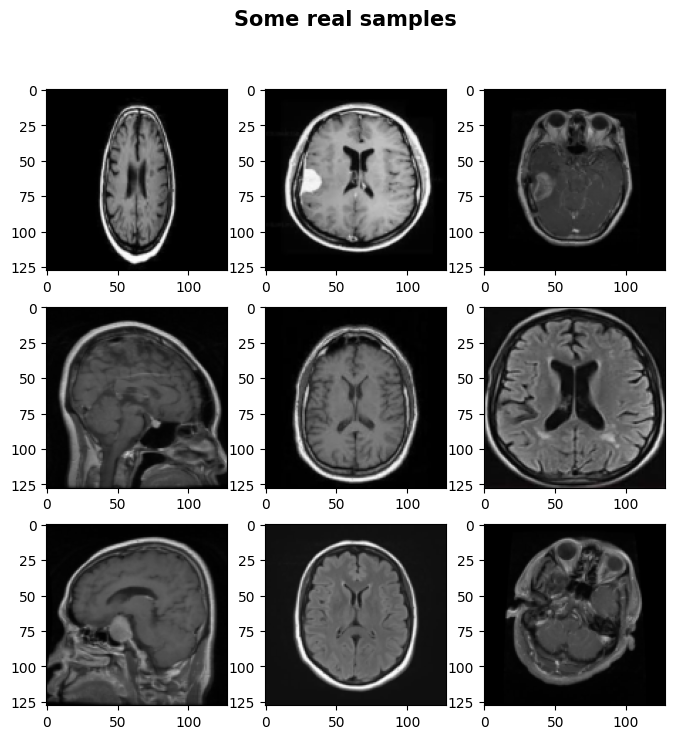

In [ ]:
def check_loader():
    loader,_ = get_loader(128)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
check_loader()

In [ ]:
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
    ):
        super(WSConv2d, self).__init__()
        self.conv      = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias      = self.conv.bias #Copy the bias of the current column layer
        self.conv.bias = None      #Remove the bias

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [ ]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [ ]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [ ]:
torch.backends.cudnn.benchmarks = True

In [ ]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )


    return alpha


In [ ]:
# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)


gen.train()
critic.train()

step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS:
    alpha = 1e-5  # start with very low alpha, you can start with alpha=0
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100)


    step += 1  # progress to the next img size

Current image size: 4
Epoch [1/5]


100%|██████████| 220/220 [00:26<00:00,  8.23it/s, gp=0.0174, loss_critic=-1.25]


Epoch [2/5]


100%|██████████| 220/220 [00:24<00:00,  9.11it/s, gp=0.01, loss_critic=-0.636]


Epoch [3/5]


100%|██████████| 220/220 [00:24<00:00,  8.95it/s, gp=0.013, loss_critic=-0.456]


Epoch [4/5]


100%|██████████| 220/220 [00:23<00:00,  9.34it/s, gp=0.0103, loss_critic=-0.163]


Epoch [5/5]


100%|██████████| 220/220 [00:23<00:00,  9.33it/s, gp=0.0131, loss_critic=-0.0713]


Current image size: 8
Epoch [1/5]


100%|██████████| 220/220 [00:28<00:00,  7.61it/s, gp=0.014, loss_critic=-0.449]


Epoch [2/5]


100%|██████████| 220/220 [00:29<00:00,  7.49it/s, gp=0.00872, loss_critic=-0.415]


Epoch [3/5]


100%|██████████| 220/220 [00:29<00:00,  7.48it/s, gp=0.00444, loss_critic=-0.612]


Epoch [4/5]


100%|██████████| 220/220 [00:28<00:00,  7.68it/s, gp=0.00778, loss_critic=-0.0246]


Epoch [5/5]


100%|██████████| 220/220 [00:29<00:00,  7.50it/s, gp=0.00628, loss_critic=-0.315]


Current image size: 16
Epoch [1/5]


100%|██████████| 220/220 [00:36<00:00,  5.97it/s, gp=0.0104, loss_critic=-2]


Epoch [2/5]


100%|██████████| 220/220 [00:36<00:00,  5.95it/s, gp=0.00974, loss_critic=-1.41]


Epoch [3/5]


100%|██████████| 220/220 [00:37<00:00,  5.93it/s, gp=0.0207, loss_critic=-2.05]


Epoch [4/5]


100%|██████████| 220/220 [00:37<00:00,  5.87it/s, gp=0.0092, loss_critic=-1.28]


Epoch [5/5]


100%|██████████| 220/220 [00:37<00:00,  5.85it/s, gp=0.0755, loss_critic=-1.2]


Current image size: 32
Epoch [1/5]


100%|██████████| 439/439 [01:52<00:00,  3.90it/s, gp=0.0743, loss_critic=-4.58]


Epoch [2/5]


100%|██████████| 439/439 [01:51<00:00,  3.93it/s, gp=0.0105, loss_critic=-1.59]


Epoch [3/5]


100%|██████████| 439/439 [01:51<00:00,  3.93it/s, gp=0.0311, loss_critic=-1.06]


Epoch [4/5]


100%|██████████| 439/439 [01:51<00:00,  3.94it/s, gp=0.00334, loss_critic=-1.12]


Epoch [5/5]


100%|██████████| 439/439 [01:51<00:00,  3.94it/s, gp=0.00131, loss_critic=-1.45]


Current image size: 64
Epoch [1/5]


100%|██████████| 439/439 [05:35<00:00,  1.31it/s, gp=0.00899, loss_critic=-6.89]


Epoch [2/5]


100%|██████████| 439/439 [05:34<00:00,  1.31it/s, gp=0.132, loss_critic=-0.814]


Epoch [3/5]


100%|██████████| 439/439 [05:34<00:00,  1.31it/s, gp=0.0353, loss_critic=-4.58]


Epoch [4/5]


100%|██████████| 439/439 [05:34<00:00,  1.31it/s, gp=0.0602, loss_critic=-1.89]


Epoch [5/5]


100%|██████████| 439/439 [05:34<00:00,  1.31it/s, gp=0.0838, loss_critic=-2.53]


Current image size: 128
Epoch [1/5]


100%|██████████| 439/439 [08:47<00:00,  1.20s/it, gp=0.176, loss_critic=-11.6]


Epoch [2/5]


100%|██████████| 439/439 [08:47<00:00,  1.20s/it, gp=0.137, loss_critic=-11.8]


Epoch [3/5]


100%|██████████| 439/439 [08:47<00:00,  1.20s/it, gp=0.0927, loss_critic=-6.83]


Epoch [4/5]


100%|██████████| 439/439 [08:46<00:00,  1.20s/it, gp=0.112, loss_critic=-6.36]


Epoch [5/5]


100%|██████████| 439/439 [08:46<00:00,  1.20s/it, gp=0.0549, loss_critic=-4.39]


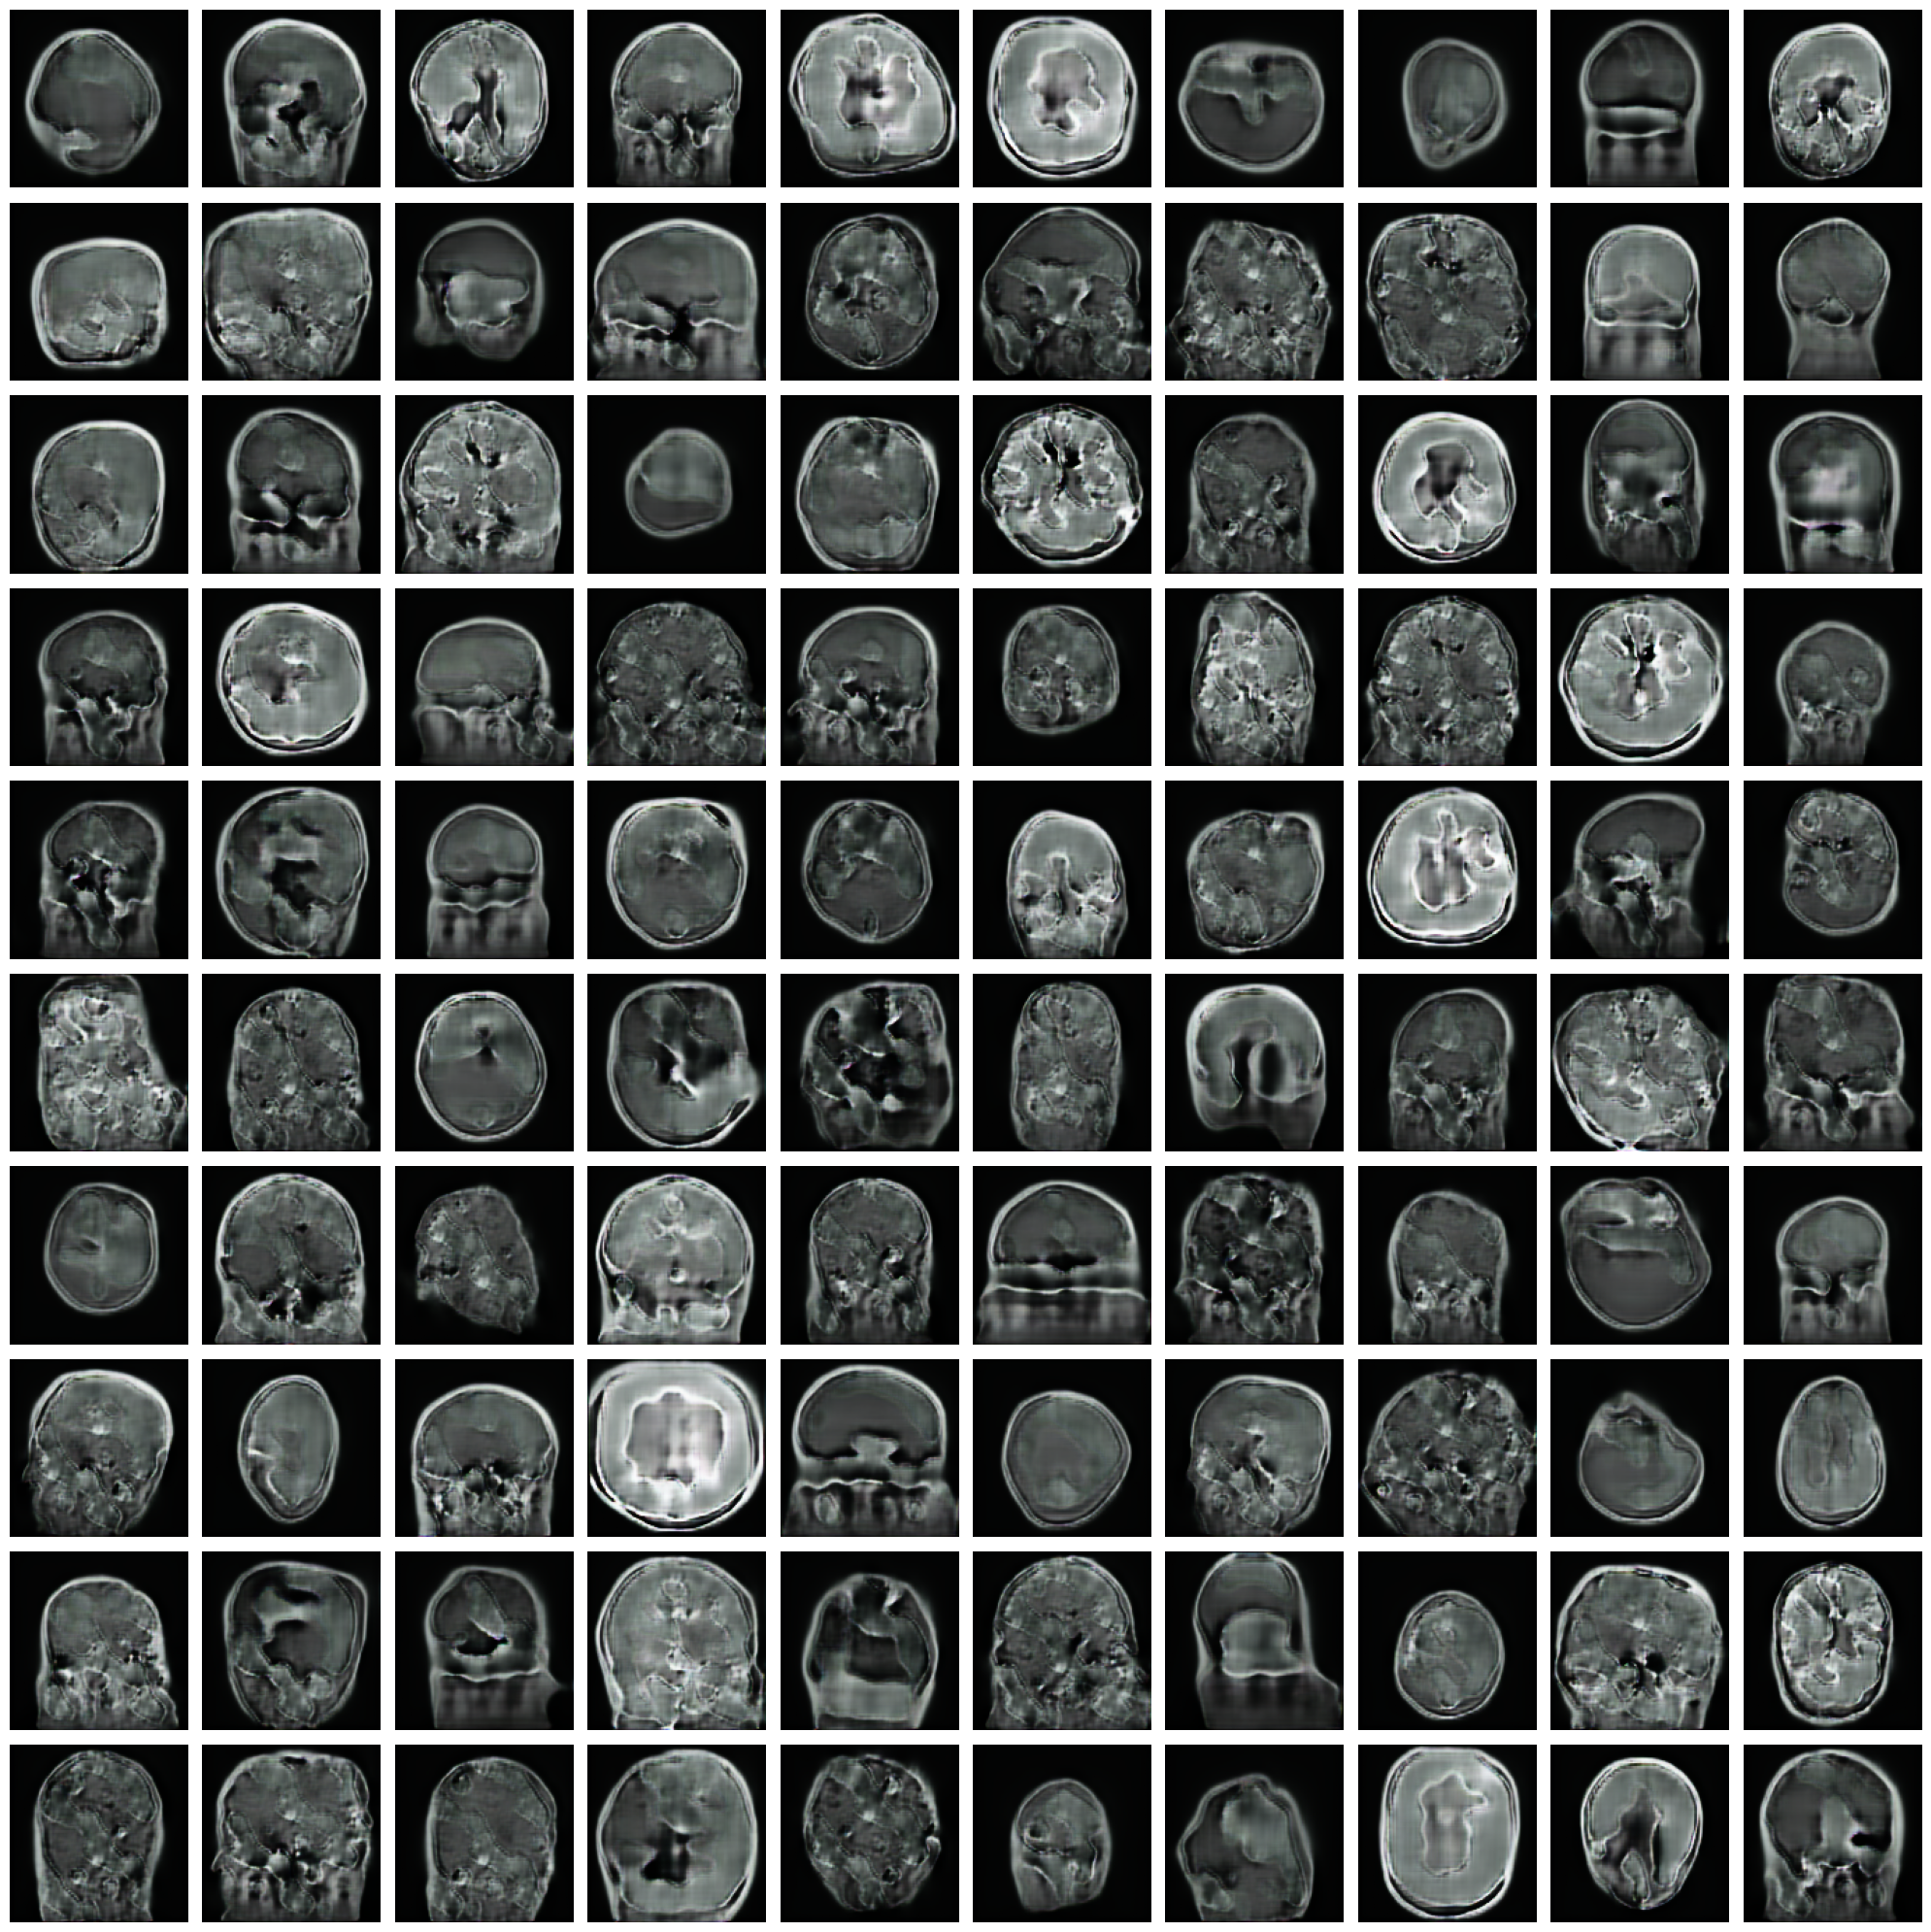

In [ ]:
# prompt: visualize generated images from step 5

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Specify the directory containing the generated images
image_dir = "saved_examples/step5"  # Replace with the actual directory


# Get a list of image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Create a figure and axes for the subplots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))  # Adjust the number of rows and columns as needed

# Iterate over the image files and display them in the subplots
for i, image_file in enumerate(image_files[:100]):  # Display up to 100 images
    if i >= 100:
        break
    img = mpimg.imread(os.path.join(image_dir, image_file))
    row = i // 10
    col = i % 10
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# prompt: save the madel as pht file and h5 and pkl

import torch
import os

# Assuming 'gen' and 'critic' are your trained generator and critic models
# ... (Your existing code)

# Save the model as a .pth file
torch.save(gen.state_dict(), 'generator.pth')
torch.save(critic.state_dict(), 'critic.pth')


# Save the model as an .h5 file (requires h5py library)
!pip install h5py
import h5py

with h5py.File('generator.h5', 'w') as hf:
    for k, v in gen.state_dict().items():
        hf.create_dataset(k, data=v.cpu().numpy())

with h5py.File('critic.h5', 'w') as hf:
    for k, v in critic.state_dict().items():
        hf.create_dataset(k, data=v.cpu().numpy())

# Save the model as a .pkl file
!pip install pickle5
import pickle5 as pickle

with open('generator.pkl', 'wb') as f:
    pickle.dump(gen, f)

with open('critic.pkl', 'wb') as f:
    pickle.dump(critic, f)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255314 sha256=bcef053e1fdccaf21c9c613ef1cedfae0935e1730edb0caa969f587e8554c40a
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5
